In [1]:
%load_ext Cython

In [17]:
%%cython
"""
regen01.pyからの変更点．
・np.loadで配列読み込み

ストークスパラメータの再構成を行うプログラム．
Planckの観測データCOM_CMB_IQU-nilc_1024_R2.02_full.fitsのI成分をLiteBIRDのTrackで観測していく．
最後の観測データはI=[I_1,I_2,I_3,...I_NPIX]のピクセルに対するIの値とLiteBIRDの重複観測ピクセルI_lu=[,,,I_lu_NPIX]の積
I_observeで
"""
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy.io as ap
import time
from joblib import Parallel, delayed
import cython
cimport numpy as cnp

def stokes(int i, cnp.ndarray pix, cnp.ndarray I_obs):#iには0からNPIXまでのintをいれる
    cdef:
        int times
        cnp.ndarray  D_mat, sum_D_pinv, D_E, wp, sum_wp, s_tilde, t
        double w

    t = np.where(pix == i)[0]#i番目のPixcelを踏んだときの時間がtに配列ではいる．

    times = t.size
    #print(times)
    w = 2*np.pi*(0.3/60)
    det = np.array([np.ones(times),np.sin(2*w*t),np.zeros(times),np.cos(2*w*t)])

    D_mat = np.array([
            [np.ones(times), np.sin(2*w*t),np.zeros(times),np.cos(2*w*t)],
            [np.sin(2*w*t),np.sin(2*w*t)**2,np.zeros(times),np.cos(2*w*t)*np.sin(2*w*t)],
            [np.zeros(times),np.zeros(times),np.zeros(times),np.zeros(times)],
            [np.cos(2*w*t),np.cos(2*w*t)*np.sin(2*w*t),np.zeros(times),np.cos(2*w*t)*np.cos(2*w*t)]
            ])
    sum_D_pinv = np.linalg.pinv(D_mat.sum(2))
    D_E = np.dot(D_mat.sum(2), sum_D_pinv)
    wp = det*I_obs[t]
    sum_wp = wp.sum(1)
    s_tilde = np.dot(sum_D_pinv, sum_wp)
    return s_tilde#0~NPIX番目までのピクセルに対するストークスパラメータが入る．



In [19]:
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)

day = 60*60*24#1日の秒数
year = day*365
times = year +1
time_array = np.arange(0,times,1)
NPIX

786432

In [4]:
start = time.time()
orbit_file = "orbit_angle.npz"

#orbit_fileからtimes秒まで読み込み，times秒間フライトしたデータを取得する．
orbit = np.load(orbit_file)
orbit = np.array([orbit["theta"][:times], orbit["phi"][:times]])

pix = hp.ang2pix(NSIDE,orbit[0],orbit[1])
pix
#ヒストグラムの処理は長い
hit_pix, bins = np.histogram(pix,bins=NPIX)


In [5]:
"""Planckのマップをreadして解析する"""
file_path = "COM_CompMap_CMB-commrul_0256_R1.00.fits"
I_planck = hp.read_map(file_path,field = 0)#PlanckのRING型データ
I_obs = I_planck[pix]#Planckのデータを観測されるpix順に並び換えた時系列観測データI_obs
I_obs

I_map = np.zeros(NPIX)
I_map[pix[:]] = I_planck[pix]



/Users/yusuke/.pyenv/versions/3.8.0/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 256
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [23]:

#0~NPIX番目までのピクセつがもつストークスパラメータが入る．
#例えば，STOK[0]は0番目のピクセルのストークスパラメータ
n=10000
zero = np.zeros(NPIX-n)
%time S_para = np.array(Parallel(n_jobs=-1, verbose=5, backend="threading")( [delayed(stokes)(i, pix, I_obs) for i in range(n)] ))

S_para = S_para.T
map = np.concatenate([S_para[0], zero])
map
#hit_time(0)
#pix_hit_timing = Parallel(n_jobs=-1, verbose=5, backend="threading")( [delayed(hit_time)(i) for i in range(NPIX)] )
#pix_hit_timing

elapsed_time0 = time.time() - start
print ("\n計算時間: {0}".format(elapsed_time0) + "[sec]")



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1144 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 2170 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 3034 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 3520 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      

CPU times: user 8min 44s, sys: 28.9 s, total: 9min 13s
Wall time: 2min 51s

計算時間: 1285.6021540164948[sec]


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  2.9min finished


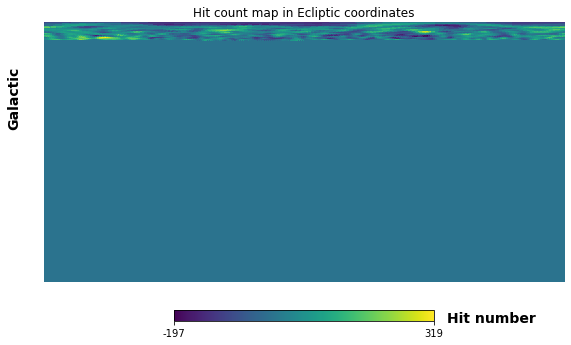

In [27]:
hp.cartview(map, coord=['G'], title="Hit count map in Ecliptic coordinates", unit="Hit number")

In [ ]:
hp.mollview(I_planck, title="I_STOKES observed by Planck", unit="mK",norm="hist", cmap="jet")
hp.mollview(map, title="LiteBIRD observation {:.4}-days".format(times/(day+1)), unit="mK",norm="hist",cmap="jet")